In [1]:
import tensorflow as tf
import numpy as np
import t3f
tf.set_random_seed(0)
np.random.seed(0)
%matplotlib inline
import matplotlib.pyplot as plt
import metric_util as mt
import data_util as du
from t3f import shapes
from nilearn import image
from skimage.measure import compare_ssim as ssim
from tensorflow.python.util import nest
import copy
from nilearn import plotting
from t3f import ops
import mri_draw_utils as mrd
from t3f import initializers
from t3f import approximate

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
#sess = tf.InteractiveSession()

In [3]:
def frobenius_norm_tf_squared(x):
    return tf.reduce_sum(x ** 2)

In [4]:
def frobenius_norm_tf(x):
    return tf.reduce_sum(x ** 2) ** 0.5

In [5]:
def relative_error1(x_hat,x_true):
    percent_error = frobenius_norm_tf(x_hat - x_true) / frobenius_norm_tf(x_true)
    return percent_error

In [6]:
def innerProduct(x, y):
    result = tf.reduce_sum(tf.multiply(x, y))
    return result

In [7]:
def compute_step_size(n_omega, grad):
    result = innerProduct(n_omega,grad)/(innerProduct(n_omega, n_omega))
    return result

In [8]:
def draw(omega, x_true, x_hat, rel_error):
    images_folder = "/work/scratch/tt1"
    ten_ones = np.ones_like(omega)
    x_reconstr1 = mt.reconstruct2(x_hat,ground_truth, omega)
    x_hat_img = mt.reconstruct_image_affine(x_true_org, x_reconstr1)
    x_hat_est = image.index_img(x_hat_img,1)
    
    x_true_org_img = image.index_img(x_true,1)
    x_miss_img = mt.reconstruct_image_affine(x_true_org, x_train)
    x_miss = image.index_img(x_miss_img,1)
    mrd.draw_original_vs_reconstructed_rim(x_true_org_img,x_hat_est, x_miss, "Rim Completion",
                                             rel_error, observed_ratio, coord=None, folder=images_folder)

In [9]:
subject_scan_path = du.get_full_path_subject1()
print "Subject Path: " + str(subject_scan_path)
x_true_org = mt.read_image_abs_path(subject_scan_path)


Subject Path: /work/pl/sch/analysis/data/COBRE001/swaAMAYER+cobre01_63001+M87100944+20110309at135133+RSTpre_V01_R01+CM.nii


In [10]:
observed_ratio = 0.4
x_true_img = np.array(x_true_org.get_data())
mask_indices = (np.random.rand(x_true_img.shape[0],x_true_img.shape[1],x_true_img.shape[2], x_true_img.shape[3]) < observed_ratio).astype('int') 
ten_ones = np.ones_like(mask_indices)
x_train = copy.deepcopy(x_true_img)
x_train[mask_indices==0] = 0.0
x_train[mask_indices == 0] = np.mean(x_train[mask_indices == 1])
#x_train[mask_indices == 0] = np.mean(x_train[mask_indices == 1])

x_init = copy.deepcopy(x_train)
#shape = (1, 53, 63, 63, 1)
#x_init_tf = t3f.random_tensor(shape, tt_rank=63)

ground_truth = copy.deepcopy(x_true_img)

sparse_observation = copy.deepcopy(ground_truth)
sparse_observation[mask_indices==0] = 0.0

In [11]:
ten_ones = np.ones_like(mask_indices)


In [12]:
norm_sparse_observation = np.linalg.norm(sparse_observation)
print norm_sparse_observation

47395410.0


In [13]:
mask_indices_tf = t3f.to_tt_tensor(mask_indices.astype('float32'), max_tt_rank=63)

[1, 53, 1, 1, 1] 0 (1, 53, 53)
[1, 53, 63, 1, 1] 1 (53, 63, 63)
[1, 53, 63, 63, 1] 2 (63, 46, 63)
ranks: [1, 53, 63, 63, 1]


In [14]:
x_miss_img = mt.reconstruct_image_affine(x_true_org, x_train)

In [15]:
x_miss = image.index_img(x_miss_img,1)

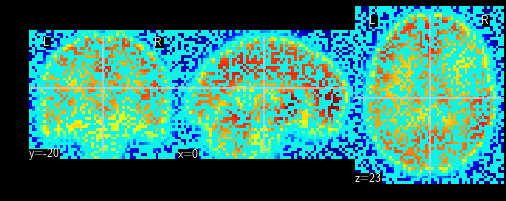

In [16]:
x_miss_image = plotting.plot_epi(x_miss, bg_img=None,black_bg=True, cmap='jet', cut_coords=None) 

In [17]:
images_folder = "/work/scratch/tt1"
mrd.draw_original_vs_reconstructed_rim(image.index_img(x_true_org,1),image.index_img(x_miss_img,1), image.index_img(x_miss_img,1), "Rim Completion",
                                             observed_ratio, observed_ratio, coord=None, folder=images_folder)

('Saving figure', '/work/scratch/tt1/missing_ratio_60.00.png')
Called from mrd


In [18]:
ground_truth_tf = t3f.to_tt_tensor(ground_truth, max_tt_rank=63)

[1, 53, 1, 1, 1] 0 (1, 53, 53)
[1, 53, 63, 1, 1] 1 (53, 63, 63)
[1, 53, 63, 63, 1] 2 (63, 46, 63)
ranks: [1, 53, 63, 63, 1]


In [19]:
A = t3f.get_variable('A', initializer=ground_truth_tf, trainable=False)

In [20]:
ground_truth = tf.get_variable('ground_truth', initializer=ground_truth, trainable=False)
sparsity_mask = tf.get_variable('sparsity_mask', initializer=mask_indices, trainable=False)
sparsity_mask = tf.cast(sparsity_mask,tf.float32)
sparse_observation = ground_truth * sparsity_mask

In [21]:
#sparsity_mask = t3f.get_variable('sparsity_mask', initializer=mask_indices_tf, trainable=False)
#sparsity_mask = t3f.cast(sparsity_mask, tf.float32)
#sparse_observation_tf = t3f.to_tt_tensor(sparse_observation, max_tt_rank=63)
#sparse_observation_tf3 = t3f.get_variable('sparse_observation_tf', initializer=sparse_observation_tf, trainable=False)

In [22]:
x_train_tf = t3f.to_tt_tensor(x_init, max_tt_rank=63)

[1, 53, 1, 1, 1] 0 (1, 53, 53)
[1, 53, 63, 1, 1] 1 (53, 63, 63)
[1, 53, 63, 63, 1] 2 (63, 46, 63)
ranks: [1, 53, 63, 63, 1]


In [23]:
normAOmegavar = tf.get_variable('normAOmega', initializer=norm_sparse_observation, trainable=False)

In [24]:
X = t3f.get_variable('X', initializer=x_train_tf)

In [25]:
print X

A Tensor Train variable of shape (53, 63, 46, 144), TT-ranks: (1, 53, 63, 63, 1)


In [26]:
def train_it_rel_cost(cost_hist, k):
    res = np.abs(cost_hist[k] - cost_hist[k-1])/np.abs(cost_hist[k])
    return res

In [27]:
counter = tf.get_variable('counter', initializer=0)

In [28]:
one = tf.constant(1)
zero_point1 = tf.constant(0.1)

In [29]:
tt_zeros = initializers.tensor_zeros([53, 63, 46, 144])

In [30]:
#eta_t3f_old = t3f.get_variable('eta_t3f_old', initializer=tt_zeros)
#grad_t3f_old = t3f.get_variable('grad_t3f_old', initializer=tt_zeros)

In [31]:
eta_old = tf.get_variable('eta_old', shape = (53, 63, 46, 144), validate_shape=False)
grad_old = tf.get_variable('grad_old', shape = (53, 63, 46, 144), validate_shape=False)

In [32]:
one = tf.constant(1)
zero_point1 = tf.constant(0.1)

In [33]:
# Algorithm
#grad_full = (t3f.full(X)*t3f.full(sparse_observation_tf3) - t3f.full(sparse_observation_tf3))
#counter_step = tf.assign(counter, counter + 1)

#grad_trans = t3f.riemannian.project(grad_t3f_old, X)
#eta_trans = t3f.riemannian.project(eta_t3f_old, X)
    
#grad_full = sparsity_mask * t3f.full(X) - sparse_observation
#grad_t3f = t3f.to_tt_tensor(grad_full, max_tt_rank=63)

#loss = 0.5 * t3f.frobenius_norm_squared(grad_t3f)
#gradnorm_omega = t3f.frobenius_norm(grad_t3f)/(normAOmegavar)

#riemannian_grad = t3f.riemannian.project(grad_t3f, X)


#eta_omega = sparsity_mask * t3f.full(-riemannian_grad)
#alpha = compute_step_size(eta_omega, grad_full)



#riemannian_grad_norm = t3f.flat_inner(riemannian_grad, riemannian_grad)



#rel_error1 = relative_error1(t3f.full(X), t3f.full(sparse_observation))




In [34]:
eps = 1e-5
epsilon_train=1e-5

In [35]:
#print grad_full

In [36]:
#print grad_t3f

In [37]:
print eps

1e-05


In [38]:
#alpha = 0.3


In [39]:
#sess = tf.Session()
#sess.run(tf.global_variables_initializer())

In [40]:
#first step

In [41]:
grad_full_0 = sparsity_mask * t3f.full(X) - sparse_observation
grad_t3f_0 = t3f.to_tt_tensor(grad_full_0, max_tt_rank=63)

gradnorm_omega_0 = t3f.frobenius_norm(grad_t3f_0)/(normAOmegavar)
riemannian_grad_0 = t3f.riemannian.project(grad_t3f_0, X)
riemannian_grad_0 = t3f.round(riemannian_grad_0, max_tt_rank =63, epsilon = 1e-15)

grad_t3f_old = t3f.get_variable('grad_t3f_old', initializer=riemannian_grad_0)

#grad_t3f_old_op = t3f.assign(grad_t3f_old, riemannian_grad_0, validate_shape=False)
riemannian_grad_full_0 = t3f.full(riemannian_grad_0)
riemannian_grad_init_op = tf.assign(grad_old,riemannian_grad_full_0)

eta_t3f_0 = -riemannian_grad_0
eta_t3f_old = t3f.get_variable('eta_t3f_old', initializer=eta_t3f_0)

eta_0 = -riemannian_grad_init_op
eta_omega_0 = sparsity_mask * t3f.full(-riemannian_grad_0)

alpha_0 = compute_step_size(eta_omega_0, riemannian_grad_init_op)
eta_op_0 = tf.assign(eta_old,eta_0, validate_shape=False)

train_step_0 = t3f.assign(X, t3f.round(X + alpha_0 * eta_t3f_0, max_tt_rank=63))



[1, 53, 1, 1, 1] 0 (1, 53, 53)
[1, 53, 63, 1, 1] 1 (53, 63, 63)
[1, 53, 63, 63, 1] 2 (63, 46, 63)
ranks: [1, 53, 63, 63, 1]
Max_TT rank63
[1, 53, 63, 63, 1]
Max_TT rank63
[1, 53, 63, 63, 1]


In [42]:
print "Rim 0:" + str(riemannian_grad_0)

Rim 0:A Tensor Train of shape (53, 63, 46, 144), TT-ranks: (1, 53, 63, 63, 1)


In [43]:
print "Eta 0: " + str(eta_t3f_0)

Eta 0: A Tensor Train of shape (53, 63, 46, 144), TT-ranks: (1, 53, 63, 63, 1)


In [44]:
#tt = t3f.round(eta_t3f_old, max_tt_rank =63, epsilon = 1e-15

In [45]:
# new
#t3f.assign(eta_t3f_old, t3f.round(eta_t3f_old, max_tt_rank =63, epsilon = 1e-15))


In [46]:
counter_step = tf.assign(counter, counter + 1)

grad_trans = t3f.riemannian.project(grad_t3f_old, X)
eta_trans = t3f.riemannian.project(eta_t3f_old, X)
    
grad_full = sparsity_mask * t3f.full(X) - sparse_observation
grad_t3f = t3f.to_tt_tensor(grad_full, max_tt_rank=63)

loss = 0.5 * t3f.frobenius_norm_squared(grad_t3f)
gradnorm_omega = t3f.frobenius_norm(grad_t3f)/(normAOmegavar)

riemannian_grad =  t3f.round(t3f.riemannian.project(grad_t3f, X),max_tt_rank =63)
#riemannian_grad = t3f.round(riemannian_grad, max_tt_rank =63, epsilon = 1e-15)

inner_product_rim_grad = t3f.flat_inner(riemannian_grad, riemannian_grad)
ip_xitrans_xi = t3f.flat_inner(grad_trans,riemannian_grad)
theta = ip_xitrans_xi / inner_product_rim_grad

# compute beta
inner_product_rim_grad_old = t3f.flat_inner(grad_t3f_old, grad_t3f_old)
beta = tf.maximum(0.0, (inner_product_rim_grad - ip_xitrans_xi)/inner_product_rim_grad_old)
#eta = -riemannian_grad + beta*eta_trans

print "Rim Grad shape: " + str(riemannian_grad)
print "eta_trans: " + str(eta_trans)

eta = approximate.add_n([-riemannian_grad, beta*eta_trans], max_tt_rank=63)

print "eta: " + str(eta)
                                            
#(1, 106, 126, 126, 1)

eta_omega = sparsity_mask * t3f.full(eta)
alpha = compute_step_size(eta_omega, grad_full)

[1, 53, 1, 1, 1] 0 (1, 53, 53)
[1, 53, 63, 1, 1] 1 (53, 63, 63)
[1, 53, 63, 63, 1] 2 (63, 46, 63)
ranks: [1, 53, 63, 63, 1]
Max_TT rank63
[1, 53, 63, 63, 1]
Rim Grad shape: A Tensor Train of shape (53, 63, 46, 144), TT-ranks: (1, 53, 63, 63, 1)
eta_trans: A Tensor Train of shape (53, 63, 46, 144), TT-ranks: (1, 106, 126, 126, 1)
Max_TT rank63
[1, 53, 63, 63, 1]
eta: A Tensor Train of shape (53, 63, 46, 144), TT-ranks: (1, 53, 63, 63, 1)


In [47]:
print eta

A Tensor Train of shape (53, 63, 46, 144), TT-ranks: (1, 53, 63, 63, 1)


In [48]:
train_step = t3f.assign(X, t3f.round(X - alpha * eta, max_tt_rank=63))

Max_TT rank63
[1, 53, 63, 63, 1]


In [49]:
eta_update_op = t3f.assign(eta_t3f_old, eta,use_locking = True)

In [50]:
grad_update_op = t3f.assign(grad_t3f_old, riemannian_grad)

In [51]:
print alpha_0

Tensor("div_1:0", shape=(), dtype=float32)


In [52]:
#t3f.round(-riemannian_grad + beta*eta_trans, max_tt_rank=[eta_trans])

In [53]:
#eta_update_op = t3f.assign(eta_t3f_old, eta,validate_shape=False, use_locking = True)

In [54]:
#grad_update_op = t3f.assign(grad_t3f_old, riemannian_grad)

In [55]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [56]:
log = []
train_loss_hist = []
#for i in range(1000):
gradnorm_val, alpha_val, eta_op_0_val,_ = sess.run([gradnorm_omega_0, alpha_0, eta_op_0, train_step_0.op])
print gradnorm_val, alpha_val

0.24615465 -1.0


In [57]:
print grad_trans

A Tensor Train of shape (53, 63, 46, 144), TT-ranks: (1, 106, 126, 126, 1)


In [58]:
#sess.run([loss])

In [59]:
#sess.run([theta])

In [60]:
#print theta

In [61]:
#sess.run([eta_trans])

In [62]:
#sess.run([eta])

In [63]:
#sess.run([train_step.op])

In [64]:
#sess.run([loss, gradnorm_omega, alpha, theta, eta_update_op, grad_update_op, train_step.op])

In [65]:


i = 0
while gradnorm_val > eps:   
#for k in range(10):
    i = i + 1
    F_v, gradnorm_val, alpha_val,theta_val, beta_val, _, _,_ = sess.run([loss, gradnorm_omega, alpha, theta, beta, train_step.op, eta_update_op.op, grad_update_op.op])
    #eta_old_val, grad_update_val,_ = sess.run([eta_update_op, grad_update_op])
    
    train_loss_hist.append(gradnorm_val)
    if i > 1:
        diff_train = np.abs(train_loss_hist[i - 1] - train_loss_hist[i-2])/np.abs(train_loss_hist[i-1])
        print (F_v, i, gradnorm_val, diff_train, alpha_val, theta_val, beta_val)
        if diff_train <= epsilon_train:
            print "Breaking after " + str(i) + " iterations"
            break
    else:
        print (F_v, i, gradnorm_val, alpha_val, theta_val, beta_val)
    log.append(F_v)

(133266030000000.0, 1, 0.34445974, -1.7783686, 0.7138214, 0.5609109)
(1619424300000.0, 2, 0.037971612, 8.0715065, -2.401021, 0.05302271, 0.010989868)
(417377750000.0, 3, 0.019277174, 0.96977067, -2.2867138, 0.047138482, 0.23071691)
(93988140000.0, 4, 0.009147771, 1.1073084, -2.3103588, 0.3939796, 0.122132406)
(32569076000.0, 5, 0.005384947, 0.698767, -2.2582881, 0.10127587, 0.21532296)
(18855995000.0, 6, 0.0040973537, 0.31425002, -2.076762, 0.19544736, 0.38757825)
(11777142000.0, 7, 0.0032381627, 0.26533285, -2.1138186, 0.33411998, 0.35192075)
(8388524500.0, 8, 0.002732886, 0.1848876, -1.9142829, 0.15661521, 0.53569704)
(6638479000.0, 9, 0.002431157, 0.1241092, -1.9798803, 0.27786407, 0.5302234)
(5311626000.0, 10, 0.0021746657, 0.117945194, -1.9134586, 0.20704898, 0.5906221)
(4428875000.0, 11, 0.001985754, 0.09513354, -1.8953286, 0.19869001, 0.61376643)
(3840721700.0, 12, 0.0018492053, 0.073841736, -1.8274317, 0.1880158, 0.6650616)
(3407056400.0, 13, 0.0017416801, 0.06173652, -1.774820

(1938638600.0, 101, 0.0013137936, 0.0012885674, -0.28053597, 0.12025511, 0.7802829)
(1939759000.0, 102, 0.0013141732, 0.0002888739, -0.2510742, 0.19692253, 0.72240955)
(1939641100.0, 103, 0.0013141333, 3.0385392e-05, -0.24176133, 0.08279284, 0.84164685)
(1942037000.0, 104, 0.0013149447, 0.0006170714, -0.21222344, 0.07506751, 0.99864763)
(1939755100.0, 105, 0.0013141719, 0.0005880242, -0.28207022, 0.25789964, 0.75331473)
(1939620900.0, 106, 0.0013141264, 3.4637756e-05, -0.16492645, -0.028523855, 0.960634)
(1939932000.0, 107, 0.0013142319, 8.0253936e-05, -0.23106638, 0.39238274, 0.6060479)
(1939118200.0, 108, 0.0013139561, 0.00020989125, -0.20782262, -0.03218155, 0.93771124)
(1940498000.0, 109, 0.0013144235, 0.00035559887, -0.2193955, 0.0814211, 1.0222005)
(1941073200.0, 110, 0.0013146183, 0.00014815162, -0.31077358, 0.28653815, 0.71391577)
(1942459400.0, 111, 0.0013150877, 0.00035692417, -0.1727259, -0.111904256, 1.2118112)
(1940935000.0, 112, 0.0013145716, 0.0003925759, -0.33712485, 0.

In [66]:
print beta

Tensor("Maximum:0", shape=(), dtype=float32)


In [67]:
#sess.run([eta_update_op.op, grad_update_op.op])

In [68]:
print X

A Tensor Train variable of shape (53, 63, 46, 144), TT-ranks: (1, 53, 63, 63, 1)


In [69]:
estimated_val = sess.run(t3f.full(X))

In [70]:
ground_truth_val = sess.run(ground_truth)


In [71]:
x_reconstr = mt.reconstruct(estimated_val,ground_truth_val, ten_ones, mask_indices)


In [72]:
def relative_error(x_hat,x_true):
    percent_error = np.linalg.norm(x_hat - x_true) / np.linalg.norm(x_true)
    return percent_error

In [73]:
rel_error = relative_error(estimated_val,ground_truth_val)

In [74]:
print rel_error

0.0033622284


In [75]:
rel_error_rec = relative_error(x_reconstr,ground_truth_val)

In [76]:
rel_error_rec

0.00266230216841754

In [77]:
x_miss_img = mt.reconstruct_image_affine(x_true_org, x_train)

In [78]:
x_miss = image.index_img(x_miss_img,1)

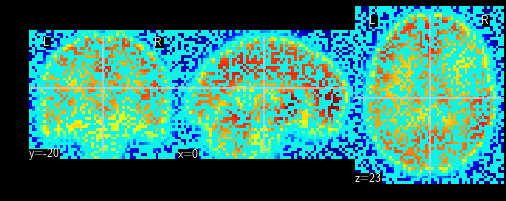

In [79]:
x_miss_image = plotting.plot_epi(x_miss, bg_img=None,black_bg=True, cmap='jet', cut_coords=None) 

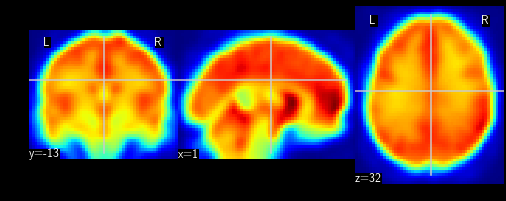

In [80]:
x_hat_img = mt.reconstruct_image_affine(x_true_org, x_reconstr)
x_hat = image.index_img(x_hat_img,1)
recovered_image = plotting.plot_epi(x_hat, bg_img=None,black_bg=True, cmap='jet', cut_coords=None)

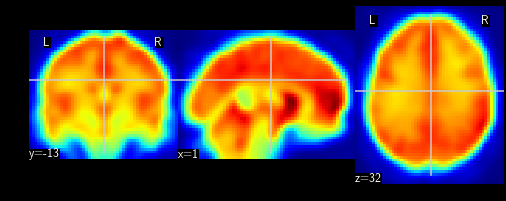

In [81]:
x_true_org_img = image.index_img(x_true_org,1)
org_image = plotting.plot_epi(x_true_org_img, bg_img=None,black_bg=True, cmap='jet', cut_coords=None)

In [82]:
images_folder = "/work/scratch/tt1/1"
mrd.draw_original_vs_reconstructed_rim(image.index_img(x_true_org,1),x_hat, image.index_img(x_miss_img,1), "Rim Completion",
                                             rel_error_rec, observed_ratio, coord=None, folder=images_folder)

('Saving figure', '/work/scratch/tt1/1/missing_ratio_60.00.png')
Called from mrd


In [83]:
estimated_val_img = mt.reconstruct_image_affine(x_true_org, estimated_val)

In [84]:
estimated_val_hat = image.index_img(estimated_val_img,1)

In [85]:
images_folder = "/work/scratch/tt1/2"
mrd.draw_original_vs_reconstructed_rim(image.index_img(x_true_org,1),estimated_val_hat,image.index_img(x_miss_img,1), "Rim Completion2",
                                             rel_error_rec, observed_ratio, coord=None, folder=images_folder)

('Saving figure', '/work/scratch/tt1/2/missing_ratio_60.00.png')
Called from mrd
